# Workshop 4

We will be building and training a basic character-level Recurrent Neural
Network (RNN) to classify words. This lab is based on Based on ["NLP From Scratch: Classifying Names with a Character-Level RNN"](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html) by [Sean Robertson](https://github.com/spro).

A character-level RNN reads words as a series of characters and for each one it (a) produces an output, and (b) updates a hidden state vector. The output hidden state from one step is in the input to the next step. In this lab, the final prediction will be made based on the last output.

The task we'll consider is predicting the language of origin of a name.
We'll train on a few thousand surnames from 18 languages
of origin, and predict which language a name is from based on the
spelling. For example:

```sh
$ python predict.py Hinton
(-0.47) Scottish
(-1.52) English
(-3.57) Irish

$ python predict.py Schmidhuber
(-0.19) German
(-2.48) Czech
(-2.68) Dutch
```

# Pre-Work

## Preparing the Data

Included in the ``names.txt`` file are a list of names, one per line, and a language they are commonly used in.
We have converted them to ASCII for convenience.

We'll read them in and make a dictionary of lists of names per language, ``{language: [names ...]}``.

In [28]:
import string
all_letters = string.ascii_letters + " .,;’"
n_letters = len(all_letters)

# Read the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = set()

with open("names.txt") as src:
    for line in src:
        parts = line.strip().split()
        category = parts[0]
        name = ' '.join(parts[1:])
        all_categories.add(category)
        category_lines.setdefault(category, []).append(name)
    
all_categories = sorted(list(all_categories))
n_categories = len(all_categories)

Now we have ``category_lines``, a dictionary mapping each category
(language) to a list of lines (names). We also kept track of
``all_categories`` (just a list of languages) and ``n_categories`` for
later reference.




In [29]:
print(category_lines['Italian'][:5])

['Abandonato', 'Abatangelo', 'Abatantuono', 'Abate', 'Abategiovanni']


### Turning Names into Tensors

Now that we have all the names organized, we need to turn them into
Tensors to make any use of them.

To represent a single letter, we use a one-hot vector of size
`<1 x n_letters>`. A one-hot vector is filled with 0s except for a 1
at index of the current letter, e.g. `"b" = <0 1 0 0 0 ...>`.
In lecture 1, we noted that usually we use special data structures to avoid memory overhead (e.g., dictionaries or sparse vectors).
In this lab, we'll use a normal vector for convenience.

To make a word we join a bunch of those into a 2D matrix
``<line_length x 1 x n_letters>``.

That extra 1 dimension is because PyTorch assumes everything is in
batches - we're just using a batch size of 1 here.




In [30]:
import torch
torch.random.manual_seed(0)

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor, one-hot-code encoding
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters) # 创建全零张量，形状为 (1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

print("This is the tensor for 'J':")
print(letterToTensor('J'))

print("\nThis is the dimensionality of the matrix for 'Jones':")
print(lineToTensor('Jones').size())

This is the tensor for 'J':
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0.]])

This is the dimensionality of the matrix for 'Jones':
torch.Size([5, 1, 57])


## Creating the Network

Before autograd, creating a recurrent neural network in Torch involved
cloning the parameters of a layer over several timesteps. The layers
held hidden state and gradients which are now entirely handled by the
graph itself. This means you can implement a RNN in a very "pure" way,
as regular feed-forward layers.

This RNN module is just 2 linear layers which operate on an input and hidden state, with
a ``LogSoftmax`` layer after the output.




In [31]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the layers of the model
        # These also create the weights where needed

        # input_size：表示当前时间步 t 的输入 x_t
        # hidden_size：表示上一时间步 t-1 的隐藏状态 h_{t-1}
        # 看forward里面的combined
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)# i2h means input to hidden
        # 这里没有使用任何的激活函数
        self.h2o = nn.Linear(hidden_size, output_size) # means hidden to output, in this layer, we do not receive token
        self.softmax = nn.LogSoftmax(dim=1)

        # Set the weights to some initial values
        self.init_weights()
        
    def init_weights(self):
        # Initialise the weights to be random values in the matrices and zero for the biases
        initrange = 0.1
        self.i2h.weight.data.uniform_(-initrange, initrange) # 初始化为 [−0.1,0.1] 之间的均匀分布随机值。
        self.i2h.bias.data.zero_() #  偏置向量 初始化为全 0。
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        
    def initHidden(self):
        # Define the initial hidden state
        # Here we use an all zero vector
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        '''
        在深度学习框架（例如 PyTorch）中，模型的权重（包括 i2h、h2h 和 h2o）
        的更新并不是我们显式地去手动更新的，而是由框架自动处理的，具体的更新流程通过 
        反向传播（backpropagation） 和 优化器（optimizer） 来完成。
        '''
        # Given an input, compute the steps defined by the model

        # Concatenate the input and hidden vectors
        combined = torch.cat((input_tensor, hidden), 1)
        
        # Apply a linear layer to get the new hidden vector
        # 这里只是调用当前层来计算结果
        hidden = self.i2h(combined)

        # Apply a linear layer to get the output scores
        output = self.h2o(hidden)

        # Use softmax to turn the scores into probabilities
        output = self.softmax(output)
        return output, hidden

n_hidden = 128
# 创建model instance
rnn = RNN(n_letters, n_hidden, n_categories)

To run a step of this network we need to pass an input (in our case, the
Tensor for the current letter) and a previous hidden state (which we
initialize as zeros at first). We'll get back the output (probability of
each language) and a next hidden state (which we keep for the next
step).

Note - we haven't trained the model yet, so it's outputs will be random.



In [32]:
input_tensor = letterToTensor('A')
hidden = torch.zeros(1, n_hidden)

'''
在 PyTorch 中，当你执行 output, next_hidden = rnn(input_tensor, hidden) 时，
forward 方法会自动被调用，这是因为 nn.Module 类已经为你实现了这个行为。


一次 forward 只是在一个批次（或单个样本）上进行前向传播计算，
而 一次 epoch 是训练过程中遍历整个训练集的过程，通常包含多个 forward 调用。

因此，一次 forward 调用不能等同于一次 epoch，而是训练过程中多个 epoch 中的一个小部分。
'''
output, next_hidden = rnn(input_tensor, hidden)

For the sake of efficiency we don't want to be creating a new Tensor for
every step, so we will use ``lineToTensor`` instead of
``letterToTensor`` and use slices. This could be further optimized by
precomputing batches of Tensors.




In [33]:
print("Running 'Albert' through the RNN, Step-by-Step")
line_tensor = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

# Pass character "A" (line_tensor[0]) into the rnn to get
# - the "output" (nLikelihood for each label for given character 'A')
# - the "next_hidden" state (hidden state for processing the next character 'l')
output, next_hidden = rnn(line_tensor[0], hidden)

print("\nFor given characters 'A'")
print(f"\nNext hidden state <{next_hidden.size()}> is:")
print(next_hidden)

print(f"\nLikelihood <{output.size()}> for each label is:")
print(output)
print("-"*20)
# Pass character "l" (line_tensor[1]), and next_hidden into the rnn to get
# - the output (nLikelihood for each label for given character 'A' and 'l')
# - the next hidden state (hidden state for processing the next character 'b')
output, next_hidden = rnn(line_tensor[1], next_hidden)

print("For given characters 'A' and 'l'")
print(f"\nNext hidden state <{next_hidden.size()}> is:")
print(next_hidden)

print(f"\nLikelihood <{output.size()}> for each label is:")
print(output)
print("-"*20)

# Continue to iterate over "b", "e", "r", "t"
output, next_hidden = rnn(line_tensor[2], next_hidden)
output, next_hidden = rnn(line_tensor[3], next_hidden)
output, next_hidden = rnn(line_tensor[4], next_hidden)
output, next_hidden = rnn(line_tensor[5], next_hidden)
# At the end, the output is nLikelihood for each label for given character 'A', 'l', 'b', 'e', 'r', t'
# We will use this output for classification

print(f"\nFor given characters 'A', 'l', 'b', 'e', 'r', t'")
print(f"Likelihood <{output.size()}> for each label is:")
print(output)

Running 'Albert' through the RNN, Step-by-Step

For given characters 'A'

Next hidden state <torch.Size([1, 128])> is:
tensor([[ 0.0650, -0.0613,  0.0333, -0.0795,  0.0739,  0.0845,  0.0280, -0.0459,
         -0.0826,  0.0137,  0.0208, -0.0218, -0.0497, -0.0360,  0.0474,  0.0464,
          0.0277, -0.0369,  0.0146, -0.0415,  0.0855,  0.0203,  0.0645, -0.0328,
         -0.0948, -0.0276,  0.0791, -0.0833,  0.0843, -0.0786,  0.0086, -0.0290,
         -0.0446,  0.0827, -0.0840,  0.0705,  0.0398, -0.0939, -0.0959,  0.0506,
          0.0038, -0.0145,  0.0291, -0.0739, -0.0482, -0.0642,  0.0851,  0.0395,
          0.0447, -0.0785,  0.0191,  0.0034,  0.0516,  0.0238, -0.0216,  0.0633,
         -0.0726, -0.0362, -0.0191,  0.0849,  0.0474,  0.0374,  0.0538,  0.0343,
         -0.0930, -0.0039, -0.0937,  0.0177,  0.0566, -0.0995, -0.0558, -0.0280,
          0.0286, -0.0865, -0.0766, -0.0717,  0.0423,  0.0426,  0.0636, -0.0992,
          0.0112,  0.0612, -0.0171, -0.0686,  0.0979,  0.0423, -0.0275,

As you can see the output is a ``<1 x n_categories>`` Tensor, where
every item is the likelihood of that category (higher is more likely).

# Workshop Tasks



## Task 1: Implement the above code using `for loop`

In [34]:
print("Running 'Albert' through the RNN using `for loop`")
line_tensor = lineToTensor('Albert')
hidden = torch.zeros(1, n_hidden)

# Solution
for i in range(line_tensor.size()[0]): # 是获取 PyTorch 张量（tensor）line_tensor 在第一个维度上的大小。
    output, hidden = rnn(line_tensor[i], hidden)

print(f"\nFor given Albert, Likelihood <{output.size()}> for each label is:")
print(output)

print(f"\nNext hidden state <{hidden.size()}> is:")
print(hidden)

Running 'Albert' through the RNN using `for loop`

For given Albert, Likelihood <torch.Size([1, 18])> for each label is:
tensor([[-2.9939, -2.7982, -2.9082, -2.9367, -2.9012, -2.8757, -2.9200, -2.8288,
         -2.8636, -2.8637, -2.9770, -2.8493, -2.9112, -2.8744, -2.8445, -2.8855,
         -2.8985, -2.9164]], grad_fn=<LogSoftmaxBackward0>)

Next hidden state <torch.Size([1, 128])> is:
tensor([[-5.1651e-02,  1.5536e-01,  8.5559e-02,  3.1779e-02,  1.0521e-02,
         -2.4438e-02, -5.5264e-02, -9.0539e-02, -6.4815e-02, -9.3608e-02,
         -4.1006e-02,  2.7128e-02,  1.0349e-01, -4.9309e-03, -4.1003e-02,
          1.3919e-01, -4.6296e-02, -8.5380e-02, -5.6727e-02,  1.1238e-01,
          8.7541e-02,  9.5509e-02,  1.5354e-02, -1.8413e-02, -8.7652e-02,
         -7.0610e-02,  7.9181e-02,  2.8588e-02,  6.4073e-02, -7.9719e-02,
         -5.5888e-03, -6.8839e-02,  3.1729e-02, -8.6611e-02,  1.1304e-01,
         -9.9707e-03,  3.2706e-03, -1.0931e-02, -2.9893e-02,  9.5714e-02,
          3.7780e-0

## Task 2

Write code using pytorch operators to convert these to probabilities by exponentiating them (ie, f(x) = exp(x)). Print the result. You should find that they are all around 5% - 6%.

In [35]:
# Solution
probs = torch.exp(output)
print(probs)

tensor([[0.0501, 0.0609, 0.0546, 0.0530, 0.0550, 0.0564, 0.0539, 0.0591, 0.0571,
         0.0571, 0.0509, 0.0579, 0.0544, 0.0564, 0.0582, 0.0558, 0.0551, 0.0541]],
       grad_fn=<ExpBackward0>)


## Training

### Preparing for Training

Before going into training we should make a few helper functions. The
first is to interpret the output of the network, which we know to be a
likelihood of each category. We can use ``Tensor.topk`` to get the index
of the greatest value:




In [36]:
def categoryFromOutput(output):
    # top_n：包含前 k 个最大值的张量。
    # top_i：包含前 k 个最大值在张量中的索引，是一种tensor，类似于tensor([1，2，3])。
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item() # 输出top_i中的第一个值，并提取出来
    return all_categories[category_i], category_i

print(categoryFromOutput(output))

('Chinese', 1)


We will also want a quick way to get a training example (a name and its
language). We use randomness here as training on the same instances in the same order can lead to worse results as we overfit that particular sequence of samples.




In [37]:
import random

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories) # 从所有类别 all_categories 中随机选择一个类别。
    line = randomChoice(category_lines[category]) # 从这个类别对应的训练数据（category_lines[category]）中随机选择一行（即一个句子）。
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

print("Here are 10 examples of randomly choosing data samples:")
for i in range(10):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    print('category =', category, '/ line =', line)

Here are 10 examples of randomly choosing data samples:
category = Polish / line = Szwarc
category = Czech / line = Quasninsky
category = Italian / line = Pontecorvo
category = French / line = Beringer
category = Spanish / line = Chavez
category = French / line = Lestrange
category = Japanese / line = Yasujiro
category = Russian / line = Tzeizik
category = Arabic / line = Maroun
category = Arabic / line = Haddad


### Training the Network

Now all it takes to train this network is show it a bunch of examples,
have it make guesses, and tell it if it's wrong.

For the loss function ``nn.NLLLoss`` is appropriate, since the last
layer of the RNN is ``nn.LogSoftmax``.




In [38]:
criterion = nn.NLLLoss()

Each loop of training will:

-  Create input and target tensors
-  Create a zeroed initial hidden state
-  Read each letter in and do the calculation, keeping the hidden state for the next letter
-  Compare final output to target
-  Back-propagate
-  Return the output and loss




In [39]:
learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden()

    rnn.zero_grad()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

Now we just have to run that with a bunch of examples. Since the
``train`` function returns both the output and loss we can print its
guesses and also keep track of loss for plotting. Since there are 1000s
of examples we print only every ``print_every`` examples, and take an
average of the loss.


In [40]:
import time
import math

n_iters = 50000
print_every = 2500
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every) # 表示每500次迭代计算一次平均损失，并将结果绘制到图表中，以便跟踪训练过程中的损失变化。
        current_loss = 0

2500 5% (0m 1s) 2.8517 Ko / Vietnamese ✗ (Korean)
5000 10% (0m 2s) 2.6615 Seif / Korean ✗ (Arabic)
7500 15% (0m 3s) 1.4088 Naser / Arabic ✓
10000 20% (0m 5s) 2.1775 Opova / Italian ✗ (Czech)
12500 25% (0m 6s) 2.0005 Kim / Korean ✗ (Vietnamese)
15000 30% (0m 7s) 2.2541 Aiza / Japanese ✗ (Spanish)
17500 35% (0m 9s) 3.4929 Olmos / Greek ✗ (Spanish)
20000 40% (0m 10s) 2.0028 Araullo / Spanish ✗ (Portuguese)
22500 45% (0m 11s) 0.1132 Hayashida / Japanese ✓
25000 50% (0m 13s) 0.5207 Paszek / Polish ✓
27500 55% (0m 14s) 0.0114 Haritopoulos / Greek ✓
30000 60% (0m 15s) 2.2480 Senft / English ✗ (German)
32500 65% (0m 16s) 0.8484 Cathasach / Irish ✓
35000 70% (0m 18s) 0.6753 Janick / Czech ✓
37500 75% (0m 19s) 1.3637 Sierra / Portuguese ✗ (Spanish)
40000 80% (0m 20s) 0.7659 Watson / Scottish ✓
42500 85% (0m 22s) 0.5092 Hung / Korean ✓
45000 90% (0m 23s) 0.4409 Messner / German ✓
47500 95% (0m 24s) 0.2713 Malouf / Arabic ✓
50000 100% (0m 26s) 1.4173 Ha / Korean ✗ (Vietnamese)


### Plotting the Results

Plotting the historical loss from ``all_losses`` shows the network
learning.

Note that learning is fast and fairly smooth at first, but then the improvements become smaller and more variable.




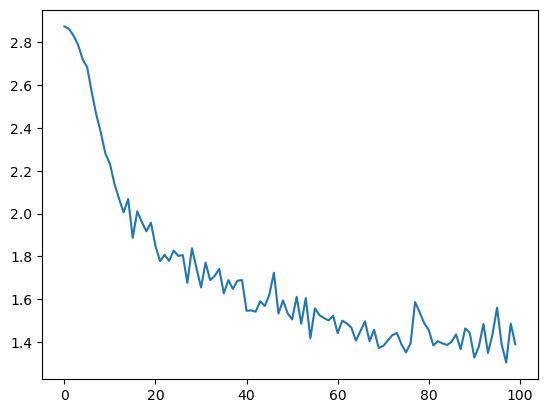

In [41]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)

## Evaluating the Results

Let's see how well the model is doing on the training data. We can get a reasonable estimate with just part of the data, so we'll run 1000 samples through the network with `evaluate()`, which is the same as `train()` minus the backpropagation.




In [42]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

56.8%


The score should be around 50-60%, which may seem low, but consider how tricky this task can be!




### Running on User Input

This function shows the output for a sample input you can provide.

In [43]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(lineToTensor(input_line))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Kummerfeld')
predict('Kay')


> Kummerfeld
(-1.04) English
(-1.85) German
(-1.93) Polish

> Kay
(-1.41) Chinese
(-1.46) Vietnamese
(-2.23) Scottish


## Task 3

Above, we trained and tested on the same data. That is misleading, because the model saw those examples during training.

In this task:
1. Modify the data reading process to split the data randomly into a test set (\~10% of the data) and train set (\~90% of the data). Train and test again.
2. Modify `randomTrainingExample` to sample from your training data. Implement a `randomTestExample` to sample from your test data.
3. Create a new instance of the model.
4. Train that instance with the training data you created.
5. Test it with the test data you created.

In [44]:
import string
import random

# 定义字符集，包括所有小写字母、大写字母、以及一些常见的标点符号
all_letters = string.ascii_letters + " .,;’"
n_letters = len(all_letters)  # 字符集的长度

# 定义类别和名字的字典，分别保存训练集和测试集的名字
category_lines = {}
all_categories = set()  # 用于保存所有类别
category_lines_train = {}  # 训练集
category_lines_test = {}   # 测试集

# 从文件中读取类别和对应的名字，并填充字典
with open("names.txt") as src:
    for line in src:
        parts = line.strip().split()  # 分割每一行
        category = parts[0]  # 类别是每一行的第一个部分
        name = ' '.join(parts[1:])  # 名字是后面的部分
        category_lines.setdefault(category, []).append(name)  # 将名字添加到对应类别的列表中
        all_categories.add(category)  # 添加类别到所有类别的集合中

# 将数据集分为训练集和测试集，10%的数据用于测试
for cat in all_categories:
    random.shuffle(category_lines[cat])  # 打乱每个类别的顺序
    split_point = int(len(category_lines[cat]) * 0.1)  # 取10%的数据作为测试集
    category_lines_train[cat] = category_lines[cat][split_point:]  # 剩下的作为训练集
    category_lines_test[cat] = category_lines[cat][:split_point]  # 10%作为测试集

all_categories = list(all_categories)  # 将所有类别转为列表

# 定义生成一个随机训练样本的函数
def randomTrainingExample():
    category = randomChoice(all_categories)  # 随机选择一个类别
    line = randomChoice(category_lines_train[category])  # 随机选择一个名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 类别转换为 tensor
    line_tensor = lineToTensor(line)  # 将名字转换为 tensor
    return category, line, category_tensor, line_tensor  # 返回训练样本

# 定义生成一个随机测试样本的函数
def randomTestExample():
    category = randomChoice(all_categories)  # 随机选择一个类别
    line = randomChoice(category_lines_test[category])  # 随机选择一个名字
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)  # 类别转换为 tensor
    line_tensor = lineToTensor(line)  # 将名字转换为 tensor
    return category, line, category_tensor, line_tensor  # 返回测试样本

# 初始化 RNN 模型
new_rnn = RNN(n_letters, n_hidden, n_categories)

# 定义训练过程中的迭代次数和打印频率
n_iters = 50000
print_every = 2500
plot_every = 500

# 用来跟踪损失值以便后续绘图
current_loss = 0
all_losses = []  # 用来保存每隔一段时间计算的平均损失
start = time.time()  # 记录开始时间

# 训练过程
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()  # 获取一个随机训练样本
    output, loss = train(category_tensor, line_tensor)  # 训练并计算损失
    current_loss += loss  # 累积当前的损失

    # 每隔一定的迭代次数打印一次训练信息
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)  # 获取模型的预测
        correct = '✓' if guess == category else '✗ (%s)' % category  # 判断预测是否正确
        # 打印迭代次数、损失、名字以及预测结果
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # 每隔一定的迭代次数，计算并保存平均损失
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)  # 记录平均损失
        current_loss = 0  # 重置当前损失

# 在测试集上评估模型的性能
total = 1000
correct = 0
# 遍历多个测试样本并记录正确的预测数量
for i in range(total):
    category, line, category_tensor, line_tensor = randomTestExample()  # 获取一个随机测试样本
    output = evaluate(line_tensor)  # 进行预测
    guess, guess_i = categoryFromOutput(output)  # 获取预测类别
    category_i = all_categories.index(category)  # 获取实际类别的索引
    if category_i == guess_i:  # 判断预测是否正确
        correct += 1

# 打印准确率
print("{}%".format(100 * correct / total))

2500 5% (0m 1s) 0.6186 Chu / Vietnamese ✓
5000 10% (0m 2s) 1.1531 Klerken / Dutch ✓
7500 15% (0m 4s) 1.8692 Smith / Arabic ✗ (Czech)
10000 20% (0m 5s) 0.6689 Cong / Chinese ✓
12500 25% (0m 6s) 0.0182 O'Mooney / Irish ✓
15000 30% (0m 8s) 3.2611 Bonnay / English ✗ (French)
17500 35% (0m 9s) 3.9193 Schneider / German ✗ (Dutch)
20000 40% (0m 10s) 3.5229 Whitaker / German ✗ (English)
22500 45% (0m 12s) 1.8959 Mclaughlin / Irish ✗ (Scottish)
25000 50% (0m 13s) 0.4411 Mai / Chinese ✓
27500 55% (0m 15s) 2.3142 Bainbridge / Dutch ✗ (English)
30000 60% (0m 16s) 0.0365 Ratti / Italian ✓
32500 65% (0m 17s) 2.4556 Desjardins / English ✗ (French)
35000 70% (0m 19s) 1.0512 Vieth / German ✓
37500 75% (0m 20s) 0.1790 Janvier / French ✓
40000 80% (0m 21s) 0.8677 Palmeiro / Portuguese ✓
42500 85% (0m 23s) 1.5210 Lafrenz / Spanish ✗ (German)
45000 90% (0m 24s) 2.7747 Schneijder / Polish ✗ (Dutch)
47500 95% (0m 25s) 4.2677 Giles / Portuguese ✗ (French)
50000 100% (0m 26s) 3.2235 Betlach / Irish ✗ (Czech)
4

## Task 4

The model is entirely linear so far. Modify it to be the basic RNN introduced in lecture 4.

Note - you can do this task without doing Task 2. It is fine to report results on the training set (as the code below does). If you want to combine task 3 and 4 that's okay too.

In the process, also change the weight initialisation to set them to be random values uniformly distributed in the range (-sqrt(k), sqrt(k)) where k is 1/hidden_size.

The cells below contains all the key code from above for easier manipulation.

In [45]:
import string
all_letters = string.ascii_letters + " .,;’"
n_letters = len(all_letters)

# Read the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = set()

with open("names.txt") as src:
    for line in src:
        parts = line.strip().split()
        category = parts[0]
        name = ' '.join(parts[1:])
        all_categories.add(category)
        category_lines.setdefault(category, []).append(name)
    
all_categories = sorted(list(all_categories))
n_categories = len(all_categories)

In [46]:
# Solution

# Model and Inference

# Find letter index from all_letters, e.g. "a" = 0
def letterToIndex(letter):
    return all_letters.find(letter)

# Just for demonstration, turn a letter into a <1 x n_letters> Tensor
def letterToTensor(letter):
    tensor = torch.zeros(1, n_letters)
    tensor[0][letterToIndex(letter)] = 1
    return tensor

# Turn a line into a <line_length x 1 x n_letters>,
# or an array of one-hot letter vectors
def lineToTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        # Define the structure of the model
        # Note that nn.Linear creates a weight matrix and a bias vector
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

        self.softmax = nn.LogSoftmax(dim=1)

        self.init_weights()

    def init_weights(self):
        initrange = math.sqrt(1 / self.hidden_size)
        self.i2h.weight.data.uniform_(-initrange, initrange)
        self.i2h.bias.data.zero_()
        self.h2o.weight.data.uniform_(-initrange, initrange)
        self.h2o.bias.data.zero_()
        self.h2h.weight.data.uniform_(-initrange, initrange)
        self.h2h.bias.data.zero_()

    def initHidden(self):
        # Define the initial hidden state for an input as all zeros
        return torch.zeros(1, self.hidden_size)

    def forward(self, input_tensor, hidden):
        # Given an input, compute the steps defined by the model
        # check RNN graph in lecture slide, you can easily understand below
        # calculate h_t 
        new_hidden = torch.tanh(self.i2h(input_tensor) + self.h2h(hidden))
        # calculate y_t
        output = torch.tanh(self.h2o(new_hidden))
        output = self.softmax(output)
        return output, new_hidden

In [47]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

# Training

n_iters = 50000
print_every = 2500 # note, we decreased this just to get more frequent updates, leaving it at 5000 is fine
plot_every = 500

criterion = nn.NLLLoss()

learning_rate = 0.005 # If you set this too high, it might explode. If too low, it might not learn

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def train(category_tensor, line_tensor):
    hidden = rnn.initHidden() # 初始化 hidden state

    rnn.zero_grad() # 梯度归零

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    # Add parameters' gradients to their values, multiplied by learning rate
    for p in rnn.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

# Keep track of losses for plotting
current_loss = 0
all_losses = []

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

2500 5% (0m 1s) 2.8604 Makino / Portuguese ✗ (Japanese)
5000 10% (0m 3s) 2.8606 Pullen / Scottish ✗ (English)
7500 15% (0m 5s) 3.3969 Hout / Korean ✗ (Dutch)
10000 20% (0m 7s) 2.3925 Lindsay / Irish ✗ (Scottish)
12500 25% (0m 9s) 1.6434 Bilias / Greek ✓
15000 30% (0m 11s) 1.8353 Joe / Korean ✗ (Chinese)
17500 35% (0m 12s) 1.3575 Agalakov / Russian ✓
20000 40% (0m 15s) 1.3112 Alexandropoulos / Greek ✓
22500 45% (0m 17s) 2.2019 Ironmonger / German ✗ (English)
25000 50% (0m 19s) 2.0372 Martin / Russian ✗ (Scottish)
27500 55% (0m 21s) 1.9844 Medina / Spanish ✓
30000 60% (0m 23s) 1.6291 Nam / Korean ✓
32500 65% (0m 25s) 1.3878 Assaf / Arabic ✓
35000 70% (0m 27s) 1.5358 Koo / Korean ✓
37500 75% (0m 28s) 1.3105 Kakinomoto / Japanese ✓
40000 80% (0m 30s) 1.7933 Zhen / Vietnamese ✗ (Chinese)
42500 85% (0m 32s) 2.1725 Dziedzic / Scottish ✗ (Polish)
45000 90% (0m 34s) 1.6558 Salcedo / Portuguese ✗ (Spanish)
47500 95% (0m 36s) 1.9936 O'Connell / Irish ✓
50000 100% (0m 37s) 1.6240 Paredes / Portugu

In [48]:
# Just return an output given a line
def evaluate(line_tensor):
    hidden = rnn.initHidden()

    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)

    return output

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

48.0%


In [49]:
# code for train/test splits

import string
import random

all_letters = string.ascii_letters + " .,;’"
n_letters = len(all_letters)

# Read the category_lines dictionary, a list of names per language
category_lines = {}
all_categories = set()
category_lines_train = {}
category_lines_test = {}

with open("names.txt") as src:
    for line in src:
        parts = line.strip().split()
        category = parts[0]
        name = ' '.join(parts[1:])
        category_lines.setdefault(category, []).append(name)
        all_categories.add(category)
for cat in all_categories:
    random.shuffle(category_lines[cat])
    split_point = int(len(category_lines[cat]) * 0.1)
    category_lines_train[cat] = category_lines[cat][split_point:]
    category_lines_test[cat] = category_lines[cat][:split_point]
all_categories = list(all_categories)

def randomTrainingExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_train[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

def randomTestExample():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines_test[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = lineToTensor(line)
    return category, line, category_tensor, line_tensor

new_rnn = RNN(n_letters, n_hidden, n_categories)

n_iters = 50000
print_every = 2500
plot_every = 500

# Keep track of losses for plotting
current_loss = 0
all_losses = []
start = time.time()
for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = randomTrainingExample()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    # Print ``iter`` number, loss, name and guess
    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (iter, iter / n_iters * 100, timeSince(start), loss, line, guess, correct))

    # Add current loss avg to list of losses
    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

total = 1000
correct = 0
# Go through a bunch of examples and record which are correctly guessed
for i in range(total):
    category, line, category_tensor, line_tensor = randomTestExample()
    output = evaluate(line_tensor)
    guess, guess_i = categoryFromOutput(output)
    category_i = all_categories.index(category)
    if category_i == guess_i:
        correct += 1
print("{}%".format(100 * correct / total))

2500 5% (0m 1s) 3.2037 Vederman / Scottish ✗ (Russian)
5000 10% (0m 3s) 1.8144 Berg / Dutch ✓
7500 15% (0m 5s) 3.2092 Gomez / Czech ✗ (Spanish)
10000 20% (0m 7s) 2.9055 Vuong / Korean ✗ (Vietnamese)
12500 25% (0m 9s) 1.3373 Lambert / French ✓
15000 30% (0m 10s) 1.4612 Fonseca / Portuguese ✓
17500 35% (0m 12s) 3.0682 Esser / Dutch ✗ (German)
20000 40% (0m 14s) 2.9608 Garofalis / French ✗ (Greek)
22500 45% (0m 16s) 1.3073 Holmogortsev / Russian ✓
25000 50% (0m 18s) 2.8715 Mackenzie / French ✗ (Scottish)
27500 55% (0m 20s) 3.0872 Sokolowski / Russian ✗ (Polish)
30000 60% (0m 22s) 2.9753 Schulze / Dutch ✗ (German)
32500 65% (0m 24s) 3.4042 Kumiega / Japanese ✗ (Polish)
35000 70% (0m 26s) 1.2212 Leveque / French ✓
37500 75% (0m 28s) 1.3840 Si / Korean ✓
40000 80% (0m 30s) 3.3155 Abana / Japanese ✗ (Spanish)
42500 85% (0m 32s) 1.5660 Emile / Scottish ✗ (French)
45000 90% (0m 33s) 2.9100 Belesis / Portuguese ✗ (Greek)
47500 95% (0m 35s) 3.3686 Aodh / Arabic ✗ (Irish)
50000 100% (0m 37s) 3.141

## Resources

For more on RNNs, see:

- [Chapter 9 of J+M](https://web.stanford.edu/~jurafsky/slp3/9.pdf)
- [Chapter 7, section 6 of E](https://github.com/jacobeisenstein/gt-nlp-class/blob/master/notes/eisenstein-nlp-notes.pdf)
-  [The Unreasonable Effectiveness of Recurrent Neural
   Networks](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) shows a bunch of real life examples
-  [Understanding LSTM
   Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) is about LSTMs specifically but also informative about RNNs in general